In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import itertools
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.gaussian_process import GaussianProcessClassifier as GPC
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, DotProduct, RationalQuadratic
from sklearn.ensemble import AdaBoostClassifier as ABC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.calibration import CalibratedClassifierCV as CCCV
from scipy.stats import mode

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from tqdm import tqdm_notebook as tqdm

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

def mallows(theta, sig0 = []): 
  if len(sig0) == 0: 
    print('need a reference permutation')
    return
#   N = len(sig0) * (len(sig0) - 1) / 2
#   if alpha > 0:
#     theta = alpha / N
#   print('theta is', theta)
  phi = np.exp(-theta)
  #get insertion probabilities 
  ws = []
  ct = 0
  for i in range(len(sig0)): 
    wi_ = []
    #formula is given with index by 1
    i = i+1
    for j in range(i): 
      j = j+1
      wij = phi**(i-j) * (1 - phi) / (1 - phi**i)
      wi_.append(wij)
      ct += 1
    ws.append(wi_)

  # sample from these ws 
  inserts = []
  for i in range(len(sig0)): 
    #to ensure sum to 1
    p_vals = ws[i] / np.sum(ws[i])
    chosen_wij = np.random.choice(len(ws[i]), p = p_vals)
    inserts.append(chosen_wij)
    
  #build the sampled permutation 
  pi = np.empty(0, dtype = int)
  for i in range(len(sig0)): 
    pi = np.insert(pi, inserts[i], sig0[i])

  return pi


def mallows_II(theta, sig0 = []): 
  if len(sig0) == 0: 
    print('need a reference permutation')
    return
#   N = len(sig0) * (len(sig0) - 1) / 2
#   if alpha > 0:
#     theta = alpha / N
#   print('theta is', theta)
  phi = np.exp(-theta)
  #get insertion probabilities 
  ws = []
  ct = 0
  for i in range(len(sig0)): 
    wi_ = []
    #formula is given with index by 1
    i = i+1
    const = (1 - phi) / (1 - phi**i)
    for j in range(i): 
      j = j+1
      wij = phi**(i-j) * const
      wi_.append(wij)
      ct += 1
    ws.append(wi_)

  # sample from these ws 
  inserts = []
  for i in range(len(sig0)): 
    #to ensure sum to 1
    p_vals = ws[i] / np.sum(ws[i])
    chosen_wij = np.random.choice(len(ws[i]), p = p_vals)
    inserts.append(chosen_wij)
    
  #build the sampled permutation 
  pi = np.empty(0, dtype = int)
  for i in range(len(sig0)): 
    pi = np.insert(pi, inserts[i], sig0[i])

  return pi

def mallows_weights(theta, n): 
    #get insertion probabilities 
    phi = np.exp(-theta)
    ws = []
    ct = 0
    for i in range(n): 
        wi_ = []
        #formula is given with index by 1
        i = i+1
        const = (1 - phi) / (1 - phi**i)
        for j in range(i): 
            j = j+1
            wij = phi**(i-j) * const
            wi_.append(wij)
            ct += 1
        ws.append(wi_)
    return ws
  
def mallows_sample(ws, sig0): 
    #sample from weights 'ws'
    inserts = []
    for i in range(len(sig0)): 
        #to ensure sum to 1
        p_vals = ws[i] / np.sum(ws[i])
        chosen_wij = np.random.choice(len(ws[i]), p = p_vals)
        inserts.append(chosen_wij)

    #build the sampled permutation 
    pi = np.empty(0, dtype = int)
    for i in range(len(sig0)): 
        pi = np.insert(pi, inserts[i], sig0[i])

    return pi

def set_plot_defaults(): 
    """Sets up default plotting values for our figures
    """
    mpl.rcdefaults()
    plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
    plt.rc('legend', fontsize=20)    # legend fontsize
    plt.rc('figure', titlesize=20)  # fontsize of the figure title
    plt.rc('legend', frameon = False) #don't add a box around legends
    plt.rc('lines', linewidth = 4) #make lines thick enough to see 
    plt.rc('axes', titlesize = 30) #make titles big enough to read

In [8]:
#precompute weights for sampling from mallows
n = 10000 #dataset size (even num)
alphas = np.logspace(-1, 1, 10)
widths = np.asarray([9, 49])

mal_wgts = {}

for alpha in tqdm(alphas): 
    for w in widths: 
        Delta = w * (w + 1) / 2
        theta = alpha / Delta
        mal_wgts[theta] = mallows_weights(theta, n)

<ipython-input-8-8bc5c8f258c8>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for alpha in tqdm(alphas):


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
preservation_dat = {} #key is (alpha, width, subset size, trial)
subset_sizes = np.asarray([200, 1000]) #subset size (middle of dataset) (even num)

n_trials = 50
sig0 = np.arange(n)

for alpha in tqdm(alphas): 
    for w in widths: 
        Delta = w * (w + 1) / 2
        theta = alpha / Delta
        wgts = mal_wgts[theta]
        for trial in range(n_trials): 
            #get sample 
            sig = mallows_sample(wgts, sig0)
            for s in subset_sizes: 
                #get preservation 
                X = np.zeros(n)
                one_start = int(np.floor(n / 2) - np.floor(s / 2))
                one_end = int(np.floor(n / 2) + np.floor(s / 2))
                X[one_start: one_end] = 1

                Z = X[sig[np.argsort(sig0)]]
                preservation_dat[(alpha, w, s, trial)] = Z[one_start: one_end].mean()

<ipython-input-10-1ffafcc4df49>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for alpha in tqdm(alphas):


  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
np.save('./preservation_dat_eta_delta.npy', preservation_dat)

# First plot $\eta$, sweeping $\alpha$, constant $\delta$

9 200 0.955
9 1000 0.991
49 200 0.315
49 1000 0.816


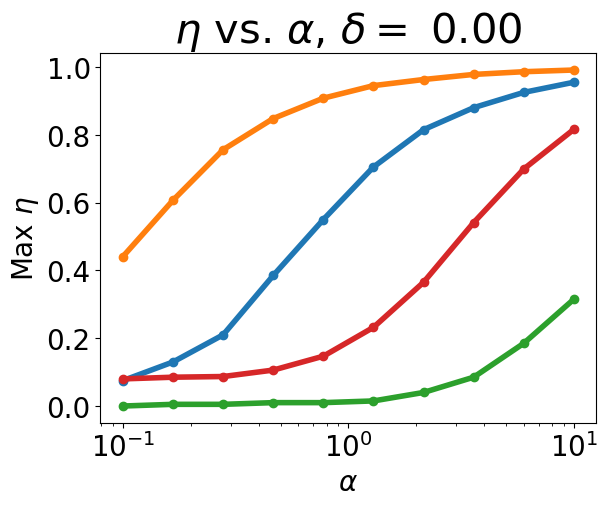

In [152]:
delta = 0.01 #probability of failure to preserve eta fraction of indices
omd_frac = int(np.ceil((1 - delta) * n_trials)) #number of trials needed to exceed probability one minus delta 
alphas = np.logspace(-1, 1, 10)
widths = np.asarray([9, 49])
subset_sizes = np.asarray([200, 1000])

set_plot_defaults()

for w in widths: 
    for s in subset_sizes: 
        curve = []
        for alpha in alphas: 
            frac_pres = []
            for trial in range(n_trials): 
                frac_pres.append(preservation_dat[(alpha, w, s, trial)])
            #get largest eta for delta
            frac_pres = np.sort(frac_pres)[::-1]
            eta = frac_pres[omd_frac - 1] #1 - delta prob eta is bigger than this eta 
            curve.append(eta)
    
        print(w,s, curve[-1])
        np.save('./eta_v_alpha_S{0:n}_W{1:n}.npy'.format(s, w), curve)
        plt.semilogx(alphas, curve, '-o', label = 'S:{0:n}%, W:{1:n}'.format(100*s/n, w))

# plt.legend(loc = 'lower left')
np.save('./alphas.npy', alphas)
plt.ylabel('Max $\\eta$')
plt.xlabel('$\\alpha$')
plt.title('$\\eta$ vs. $\\alpha$, $\\delta =$ {0:.2f}'.format(delta))
plt.show()

# Now re-run varying widths and subset sizes 

In [139]:
#precompute weights for sampling
n = 10000 #dataset size (even num)
alpha = 3 
widths = np.linspace(1, 200, 21, dtype = int)
widths[0] = 2

mal_wgts = {}

# for w in tqdm(widths): 
for w in tqdm(widths): 
    Delta = w * (w + 1) / 2
    theta = alpha / Delta
    mal_wgts[theta] = mallows_weights(theta, n)

<ipython-input-139-8764e840fde7>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for w in tqdm(widths):


  0%|          | 0/21 [00:00<?, ?it/s]

In [142]:
preservation_dat_B = {} #key is (width, subset size, trial)
sigs = {} #store permutations, key is (width, trial)
subset_sizes = np.linspace(1, 10000, 21, dtype = int) #subset size (middle of dataset) (even num)
subset_sizes[0] = 100

n_trials = 50
sig0 = np.arange(n)

# for w in tqdm(widths): 
for w in tqdm(widths): 
    Delta = w * (w + 1) / 2
    theta = alpha / Delta
    wgts = mal_wgts[theta]
    for trial in range(n_trials): 
        #get sample 
        sig = mallows_sample(wgts, sig0)
        sigs[(w, trial)] = sig
        for s in subset_sizes: 
            #get preservation 
            X = np.zeros(n)
            one_start = int(np.floor(n / 2) - np.floor(s / 2))
            one_end = int(np.floor(n / 2) + np.floor(s / 2))
            X[one_start: one_end] = 1

            Z = X[sig[np.argsort(sig0)]]
            preservation_dat_B[(w, s, trial)] = Z[one_start: one_end].mean()

<ipython-input-142-9d7752336ef4>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for w in tqdm(widths):


  0%|          | 0/21 [00:00<?, ?it/s]

In [153]:
np.save('./preservation_dat_eta_delta_B.npy', preservation_dat_B)

# Now plot $\eta$ sweeping $w$

0.01 0.0
0.2 0.1885
0.4 0.40225
0.6 0.6043333333333333
0.8 0.801125
1.0 1.0


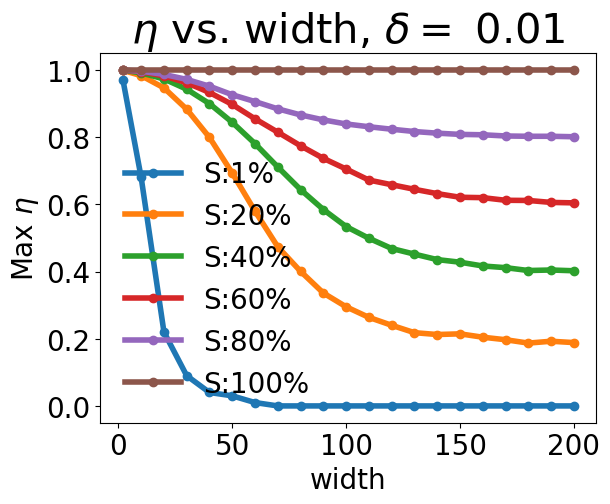

In [156]:
delta = 0.01 #probability of failure to preserve eta fraction of indices
omd_frac = int(np.ceil((1 - delta) * n_trials)) #number of trials needed to exceed probability one minus delta 

widths = np.linspace(1, 200, 21, dtype = int)
widths[0] = 2
subset_sizes = np.linspace(1, 10000, 21, dtype = int) #subset size (middle of dataset) (even num)
subset_sizes[0] = 100

set_plot_defaults()


 
for s in subset_sizes[::4]: 
    curve = []
    for w in widths: 
        frac_pres = []
        for trial in range(n_trials): 
            frac_pres.append(preservation_dat_B[(w, s, trial)])
        #get largest eta for delta
        frac_pres = np.sort(frac_pres)[::-1]
        eta = frac_pres[omd_frac - 1] #1 - delta prob eta is bigger than this eta 
        curve.append(eta)

    print(s/10000, curve[-1])
    np.save('./eta_v_width_S{0:n}.npy'.format(s), curve)
    plt.plot(widths, curve, '-o', label = 'S:{0:n}%'.format(100*s/n))

np.save('./widths.npy', widths)
plt.ylabel('Max $\\eta$')
plt.xlabel('width')
plt.legend(loc = 'lower left')
plt.title('$\\eta$ vs. width, $\\delta =$ {0:.2f}'.format(delta))
plt.show()

# Now plot $\eta$ sweeping subset size

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0


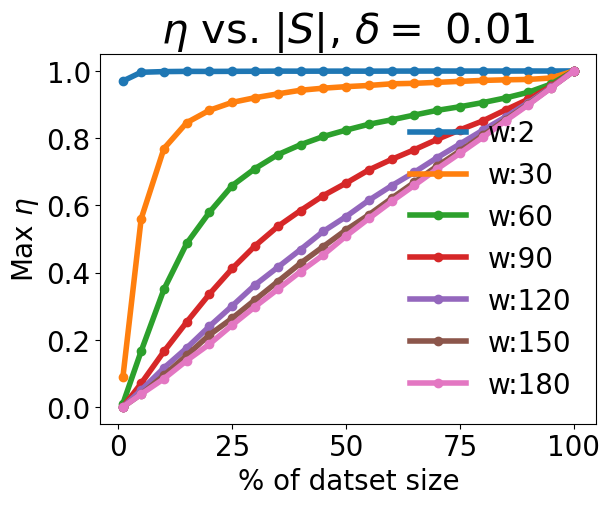

In [157]:
delta = 0.01 #probability of failure to preserve eta fraction of indices
omd_frac = int(np.ceil((1 - delta) * n_trials)) #number of trials needed to exceed probability one minus delta 

set_plot_defaults()

for w in widths[::3]:
    curve = []
    for s in subset_sizes:
        frac_pres = []
        for trial in range(n_trials): 
            frac_pres.append(preservation_dat_B[(w, s, trial)])
        #get largest eta for delta
        frac_pres = np.sort(frac_pres)[::-1]
        eta = frac_pres[omd_frac - 1] #1 - delta prob eta is bigger than this eta 
        curve.append(eta)
        
    np.save('./eta_v_subset_W{0:n}.npy'.format(w), curve)
    print(s/10000, curve[-1])
    plt.plot(100 * subset_sizes/n, curve, '-o', label = 'w:{0:n}'.format(w))

np.save('./subset_sizes.npy', subset_sizes)
plt.ylabel('Max $\\eta$')
plt.xlabel('% of datset size')
plt.legend(loc = 'lower right')
plt.title('$\\eta$ vs. $|S|$, $\\delta =$ {0:.2f}'.format(delta))
plt.show()